<a href="https://colab.research.google.com/github/Jorbnc/MAIA-DL/blob/master/Mini_Proyecto_3_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

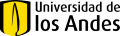

<style>
@import url('https://fonts.googleapis.com/css2?family=Latin+Modern+Roman:wght@400;700&display=swap');

body, p, h1, h2, h3, h4, h5, h6, li {
  font-family: 'Latin Modern Roman', serif;
}
code, pre {
  font-family: 'Fira Mono', monospace;
}
</style>

***

# **Miniproyecto 3, Técnicas de *Deep Learning*: ...**

## **Descripción del problema:**

...

## **Objetivo:**

...

***

**Este proyecto es realizado por Andrés Felipe Ñungo y Jordan Bryan Núñez Campos para entrega el 13 de mayo de 2025.**



***
# **Índice**

El *notebook* aborda el proyecto con la siguiente estructura:

| 🔹 | Sección        |
|----|----------------|
| 1️⃣. | **Instalación y carga de librerías** |
| 1️⃣.1️⃣. | **Word2Vec** |
| 1️⃣.2️⃣. | **GloVe** |
| 1️⃣.3️⃣. | **Configuraciones adicionales** |
| 2️⃣. | **Análisis exploratorio y preparación de los datos**       |
| 2️⃣.1️⃣. | **Carga y estadísticas generales**       |
| 2️⃣.2️⃣. | **Limpieza de los datos**       |
| 3️⃣. | **Definición de *pipelines* de procesamiento**          |
| 3️⃣.1️⃣. | **Pipeline de preprocesamiento**   |
| 4️⃣. | **Desarrollo del modelo RNN**   |
| 4️⃣.1️⃣. | **Hiperparámetros, Partición y DataLoaders**   |
| 4️⃣.2️⃣. | **Definición del modelo**   |
| 4️⃣.3️⃣. | **Entrenamiento, validación y prueba**   |
| 5️⃣. | **Análisis de resultados y discusión**   |
| 5️⃣.1️⃣. | **Pruebas individuales del modelo**   |
| 6️⃣. | **Conclusión**   |
| 7️⃣. | **Referencias**   |


***

# 1. Instalación y carga de librerías

....

In [1]:
# Instalación de librerías necesarias para correr en Colab/Coursera
!pip -q install kagglehub langdetect wordcloud matplotlib scikit-learn plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 18.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
# Librerías comunes
import os, random, gc, copy, time, pickle, math
import subprocess
from pathlib import Path
import numpy as np
import pandas as pd
from collections import defaultdict

# Descarga de datasets y de embeddings
import kagglehub

# Limipieza y preparación de los txtos
from langdetect import detect, DetectorFactory
import re

# Preprocesamiento y herramientas de PLN
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from transformers import (BertTokenizer,
                          BertForSequenceClassification,
                          get_linear_schedule_with_warmup)

# Modelado
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup,
)


# Evaluación
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
)

# Librerías para visualizaciones
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud

Uses “bert-base-uncased” version of BERT, which is pre-trained on lower-cased English text

(with 12-layer, 768-hidden, 12-heads, 110M parameters)

For the purposes of fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the BERT paper: https://arxiv.org/pdf/1810.04805.pdf):

*   **Batch size:** 16, 32
*   **Learning rate (Adam):** 5e-5, 3e-5, 2e-5
*   **Number of epochs:** 2, 3, 4

[1]

In [3]:
#Parámetros globales de los modelos
TEXT_COL   = "text"
LABEL_COL  = "labels"                    # columna con la categoría en texto
MAX_LEN    = 256
BATCH_SIZE = 16
EPOCHS     = 6
PATIENCE   = 2
UNFREEZE_PER_EPOCH = 2                 # capas a liberar por época
SEED = 13

Se descarga el conjunto de datos de reseñas de noticias de la BBC de **`kagglehub`**. La función **`dataset_download`** guarda los archivos de manera local y devuelve la ruta absoluta, que se almacena en **`path`** y se muestra en pantalla mediante **`print`** para confirmar dónde quedaron los datos.

## 1.3. Configuraciones adicionales

Con el siguiente bloque se detecta si el entorno dispone de GPU y selecciona el **`device`** apropiado para PyTorch.  

Primero se llama a **`is_available()`**, que devuelve *True* si se ha asignado una GPU CUDA al *runtime* de Colab. Según el resultado se imprime un mensaje informativo. Posteriormente, se construye el objeto **`device`**, que será pasado a la red y a los tensores de entrada para que se ubiquen en la GPU cuando sea posible. Por último se muestra en pantalla el dispositivo elegido.

In [4]:
# Devuelve asignación de GPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo activo → {DEVICE}")

Dispositivo activo → cpu


Adicionalmente se ocultan avisos para mantener limpias algunas salidas del notebook; y se imprimen las versiones de un conjunto de librerías clave ( **`numpy`**, **`pandas`**, **`torch`**, **`scikit-learn`**, **`kagglehub`**, **`matplotlib`**). Mostrar estas versiones al inicio del notebook facilita la reproducibilidad y ayuda a depurar posibles conflictos de dependencias.

In [5]:
# Ignorar las warnings
import warnings
warnings.filterwarnings("ignore")

# Versiones utilizadas
from importlib.metadata import version
librerias = ["numpy", "pandas", "torch", "scikit-learn", "kagglehub","matplotlib"]
for library in librerias:
  print(library, ": ", version(library))

numpy :  2.0.2
pandas :  2.2.2
torch :  2.6.0+cu124
scikit-learn :  1.6.1
kagglehub :  0.3.12
matplotlib :  3.10.0
nltk :  3.9.1


Finalmente, para cerrar esta sección se configuran algunas semillas para tener cierto grado de control en la aleatoriedad.

In [6]:
# Definición del random state y seeds

random.seed(SEED);
np.random.seed(SEED);
torch.manual_seed(SEED);
torch.cuda.manual_seed_all(SEED);

***

# 2. Análisis exploratorio y preparación de los datos


***

## 2.1. Carga y estadísticas generales

In [7]:
# Leer el conjunto de datos y cargarlo a un dataframe

# Descarga del conjunto de datos
path = kagglehub.dataset_download("jacopoferretti/bbc-articles-dataset")
print("Datos descargados en:", path)

CSV_PATH = os.path.join(path, "bbc_news_text_complexity_summarization.csv")
print(f"Dataset descargado en: {CSV_PATH}")

data_raw = pd.read_csv(CSV_PATH)
print("Filas totales:", len(data_raw))

100%|██████████| 5.50M/5.50M [00:00<00:00, 7.53MB/s]

Extracting files...


Datos descargados en: /root/.cache/kagglehub/datasets/jacopoferretti/bbc-articles-dataset/versions/8
Dataset descargado en: /root/.cache/kagglehub/datasets/jacopoferretti/bbc-articles-dataset/versions/8/bbc_news_text_complexity_summarization.csv
Filas totales: 2127


***

## 2.2. Limpieza de los datos

En estas sección identificamos y corregimos:

* Valores faltantes
* Textos duplicados
* Textos en otros idiomas distintos al inglés

In [8]:
data_raw.isna().sum()

,0
text,0
labels,0
no_sentences,0
Flesch Reading Ease Score,0
Dale-Chall Readability Score,0
text_rank_summary,0
lsa_summary,0


In [9]:
data_raw.duplicated().sum()

np.int64(0)

In [10]:
df = data_raw.copy()

In [11]:
# 2.1. Carga y estadísticas  ➜  justo después de copiar el DataFrame

le = LabelEncoder()
df["label_id"] = le.fit_transform(df[LABEL_COL])

NUM_LABELS = len(le.classes_)      # 👈  siempre un entero

id2label = {i: lbl for i, lbl in enumerate(le.classes_)}
label2id = {v: k for k, v in id2label.items()}

In [12]:
# Gráfica para mostrar distribución de las clases

In [13]:
def detectar_idiomas(df: pd.DataFrame,
                     col_texto: str = 'text') -> pd.DataFrame:
    """
    Detecta el idioma de cada fila en la columna **col_texto**,
    añade la columna **idioma** y muestra ejemplos no ingleses.
    """
    # Inicializamos con 'desconocido'
    df['idioma'] = 'desconocido'

    # Función auxiliar segura
    def _detectar(texto):
        if isinstance(texto, str) and texto.strip():
            try:
                return detect(texto)
            except Exception:
                return 'desconocido'
        return 'desconocido'

    # Aplicamos detección
    df['idioma'] = df[col_texto].apply(_detectar)

    # Filtramos los que no son inglés
    mask = df['idioma'] != 'en'
    idx_no_en = df[mask].index

    if len(idx_no_en) > 0:
        print(f"Se encontraron {len(idx_no_en)} textos NO en inglés (ejemplos):")
        # Mostramos hasta 5 ejemplos
        for i in idx_no_en[:5]:
            print(f" • Índice {i}: [{df.at[i,'idioma']}] {df.at[i,col_texto][:100]}...")
    else:
        print("Todos los textos están detectados como inglés.")

    return df

Nota: En algunas ocasiones, la función `detect` confunde la presencia de nombres propios o pequeñas secciones en otros idiomas como un indicativo de que el texto no está en inglés. Sin embargo, estas ocurrencias suelen ser mínimas o nulas.

Detectando otros idiomas:

In [14]:
df = detectar_idiomas(df, col_texto='text')

Todos los textos están detectados como inglés.


***

# 3. Definición de *pipelines* de procesamiento

***

## 3.1. *Pipeline* de preprocesamiento

....

In [15]:
# Limpieza básica
def clean_text(text: str) -> str:
    text = re.sub(r"\s+", " ", text)            # colapsar whitespace
    text = re.sub(r"[^\w.,;:!?()¿¡ ]+", "", text)
    return text.strip()

for col in ("text", "text_rank_summary", "lsa_summary"):
    if col in df.columns:
        df[col] = df[col].astype(str).apply(clean_text)


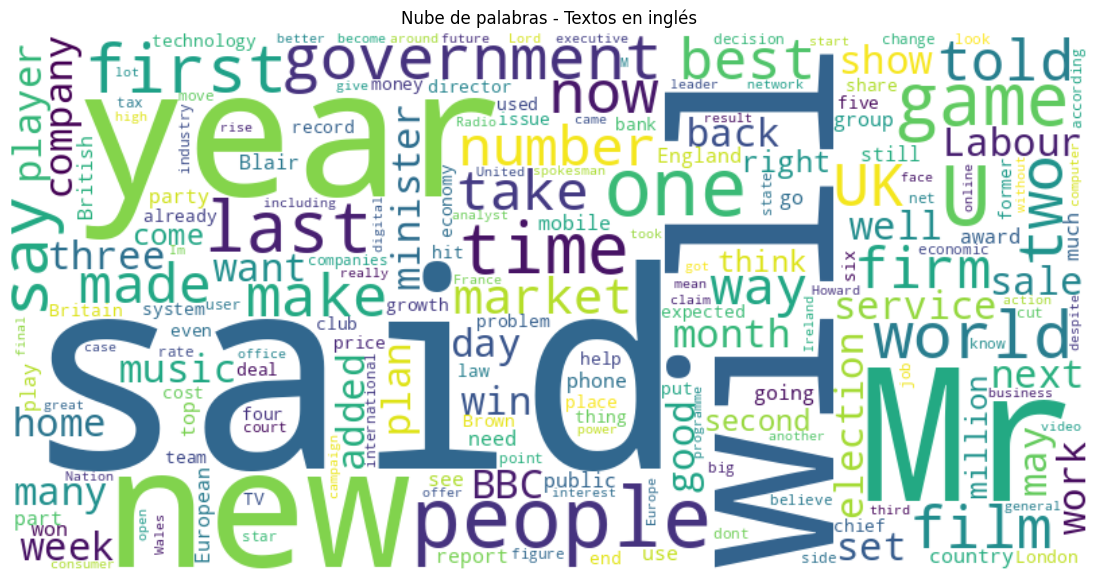

In [16]:
# --- 4.b. Nube de palabras para artículos en inglés ---
# Unimos todos los textos limpios de la columna 'text' detectados como inglés
textos_en = ' '.join(df[df['idioma'] == 'en']['text'].tolist())

# Creamos la nube de palabras
wc = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=200,
    collocations=False  # evita duplicados de bigramas
).generate(textos_en)

# Mostramos la figura
plt.figure(figsize=(15, 7))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras - Textos en inglés')
plt.show()


In [17]:
train_df, test_df = train_test_split(
    df, test_size=0.10, stratify=df["label_id"], random_state=SEED
)
train_df, val_df = train_test_split(
    train_df, test_size=0.10, stratify=train_df["label_id"], random_state=SEED
)
print("Tamaños – Train / Val / Test:", len(train_df), len(val_df), len(test_df))

Tamaños – Train / Val / Test: 1722 192 213


[2]

***

# 4. Desarrollo del modelo RNN

***

## 4.1. Hiperparámetros, partición y *DataLoaders*

...

In [18]:
class BBCDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.texts  = df[TEXT_COL].tolist()
        self.labels = df["label_id"].tolist()
        self.tok    = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tok(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

In [19]:
def build_dataloaders(splits, tokenizer, max_len, batch_size, num_workers=2):
    """Crea DataLoaders evitando referencias fantasma."""
    return {
        k: DataLoader(
            BBCDataset(df_split, tokenizer, max_len),
            batch_size=batch_size,
            shuffle=(k == "train"),
            num_workers=num_workers,
            pin_memory=True,
        )
        for k, df_split in splits.items()
    }

In [ ]:
# -----------------------------------------------------
# 4. Utilidades de congelado / descongelado
# -----------------------------------------------------

def freeze_encoder(model, freeze: bool = True):
    """Congela o descongela todo el encoder base."""
    for param in model.base_model.parameters():
        param.requires_grad = not freeze

def unfreeze_last_n_layers(model, n: int):
    """Activa gradientes en las *n* últimas capas del encoder."""
    if not hasattr(model.base_model, "encoder"):
        return  # modelos tipo RoBERTa/BERT comparten estructura
    layers = model.base_model.encoder.layer
    for layer in layers[-n:]:
        for p in layer.parameters():
            p.requires_grad = True

In [20]:
# -----------------------------------------------------
# 4. Función train_and_evaluate  >>> MODIFIED <<<
# -----------------------------------------------------


def train_and_evaluate(model_name: str, train_df, val_df, test_df):
    print(f"\n========== Entrenando {model_name} ==========")

    # Tokenizer + modelo
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=NUM_LABELS,
        id2label=id2label,
        label2id=label2id,
    ).to(device)

    # 5.1 Congelar encoder completo y luego liberar gradualmente
    freeze_encoder(model)

    # 5.2 Pesos de clase balanceados
    class_weights = compute_class_weight(
        class_weight="balanced", classes=np.arange(NUM_LABELS), y=train_df["label_id"]
    )
    class_weights = torch.tensor(class_weights, dtype=torch.float32, device=device)

    # 5.3 DataLoaders
    loaders = {
        "train": build_dataloader(train_df, tokenizer, "train"),
        "val":   build_dataloader(val_df,   tokenizer, "val"),
        "test":  build_dataloader(test_df,  tokenizer, "test"),
    }

    # 5.4 Optimizador & scheduler
    total_steps = len(loaders["train"]) * EPOCHS
    optimizer   = AdamW(model.parameters(), lr=2e-5, weight_decay=1e-2)
    scheduler   = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.06 * total_steps),
        num_training_steps=total_steps,
    )

    criterion   = torch.nn.CrossEntropyLoss(weight=class_weights)

    best_f1, patience_cnt = 0.0, 0
    best_path = f"best_{model_name.split('-')[0]}_bbc.pt"

    def epoch_pass(split):
        is_train = split == "train"
        model.train() if is_train else model.eval()
        losses, preds_all, trues_all = [], [], []

        for batch in loaders[split]:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.set_grad_enabled(is_train):
                outputs = model(**{k: v for k, v in batch.items() if k != "labels"})
                loss = criterion(outputs.logits, batch["labels"])
                if is_train:
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                    optimizer.step(); scheduler.step(); optimizer.zero_grad()

            losses.append(loss.item())
            preds_all.extend(outputs.logits.argmax(dim=-1).cpu().numpy())
            trues_all.extend(batch["labels"].cpu().numpy())

        acc = accuracy_score(trues_all, preds_all)
        f1m = f1_score(trues_all, preds_all, average="macro", zero_division=0)
        f1µ = f1_score(trues_all, preds_all, average="micro", zero_division=0)
        return np.mean(losses), acc, f1m, f1µ

    # 5.5 Entrenamiento
    for epoch in range(1, EPOCHS + 1):
        unfreeze_last_n_layers(model, epoch * UNFREEZE_PER_EPOCH)
        train_loss, train_acc, train_f1m, train_f1µ = epoch_pass("train")
        val_loss,   val_acc,   val_f1m,   val_f1µ   = epoch_pass("val")

        print(f"Ep {epoch:02d}: \tTL {train_loss:.4f} / VL {val_loss:.4f} | "
              f"F1_macro {val_f1m:.3f}  Acc {val_acc:.3f}")

        if val_f1m > best_f1:
            best_f1 = val_f1m
            patience_cnt = 0
            torch.save(model.state_dict(), best_path)
        else:
            patience_cnt += 1
            if patience_cnt == PATIENCE:
                print("Early stopping ↯\n")
                break

    # 5.6 Evaluación sobre *test*
    model.load_state_dict(torch.load(best_path))
    test_loss, test_acc, test_f1m, test_f1µ = epoch_pass("test")

    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for batch in loaders["test"]:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**{k: v for k, v in batch.items() if k != "labels"})
            y_true.extend(batch["labels"].cpu().numpy())
            y_pred.extend(outputs.logits.argmax(dim=-1).cpu().numpy())

    report = classification_report(
        y_true,
        y_pred,
        labels=list(range(NUM_LABELS)),
        target_names=le.classes_.tolist(),
        digits=3,
        zero_division=0,
    )

    # 5.7 Limpieza explícita
    del loaders, optimizer, scheduler, criterion
    gc.collect(); torch.cuda.empty_cache()

    metrics = {
        "model": model_name,
        "test_acc": test_acc,
        "test_f1_macro": test_f1m,
        "test_f1_micro": test_f1µ,
        "report": report,
    }
    return metrics

....

***

## 4.3. Entrenamiento, validación y prueba

 **`gradient clipping`** m

In [ ]:
if __name__ == "__main__":
    start = time.time()

    MODELS = {
        "bert-base-uncased": "BERT",
        "roberta-base": "RoBERTa",
    }

    results = []
    histories = {}
    for mdl_name, label in MODELS.items():
        m = train_and_evaluate(mdl_name, train_df, val_df, test_df)
        results.append(m)
        histories[label] = m["history"]
        print("\n>>> Reporte detallado:")
        print(m["report"])
        print("="*60)

    # tabla comparativa
    print("\n======= Comparativa final =======")
    for res in results:
        print(f"{MODELS[res['model']]:9s} | Acc {res['test_acc']:.3f} | F1_macro {res['test_f1_macro']:.3f} | F1_micro {res['test_f1_micro']:.3f}")

    dur = (time.time() - start) / 60
    print(f"\nTiempo total: {dur:.1f} min\n")

In [21]:
def plot_history(hist):
    epochs = list(range(1,len(hist['train_loss'])+1))
    plt.figure(figsize=(8,4))
    plt.plot(epochs,hist['train_loss'],label='Train Loss')
    plt.plot(epochs,hist['val_loss'],label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss vs Epoch'); plt.legend(); plt.show()

    plt.figure(figsize=(8,4))
    plt.plot(epochs,hist['train_acc'],label='Train Acc')
    plt.plot(epochs,hist['val_acc'],label='Val Acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy vs Epoch'); plt.legend(); plt.show()


In [ ]:
plot_history(histories["BERT"])         # igual que hist_bert
plot_history(histories["RoBERTa"])      # igual que hist_roberta

[3]

...

***


# 5. Análisis de resultados y discusión

...

...

In [ ]:
# Mariz de confusión de ambos modelos

In [ ]:
# ——————————————————————————————————————————————
# 10. t-SNE 3D de los embeddings de entrada
# ——————————————————————————————————————————————

N = 500  # número de tokens a mostrar por vocabulario

# 1) Obtener los N primeros tokens de cada tokenizer
tokens_bert    = list(tokenizer_bert.get_vocab().keys())[:N]
tokens_roberta = list(tokenizer_roberta.get_vocab().keys())[:N]

# 2) Extraer sus vectores de embedding
#    get_input_embeddings().weight es [vocab_size x hidden_size]
emb_bert    = model_bert.get_input_embeddings().weight.detach().cpu().numpy()
emb_roberta = model_roberta.get_input_embeddings().weight.detach().cpu().numpy()

# 3) Indexar sólo los tokens seleccionados
ids_bert    = [tokenizer_bert.convert_tokens_to_ids(t) for t in tokens_bert]
ids_roberta = [tokenizer_roberta.convert_tokens_to_ids(t) for t in tokens_roberta]

vecs_bert    = emb_bert[ids_bert, :]
vecs_roberta = emb_roberta[ids_roberta, :]

# 4) Concatenar y normalizar
V = np.vstack([vecs_bert, vecs_roberta])
V = StandardScaler().fit_transform(V)

# 5) Reducir dimensionalidad con PCA a 50 componentes
pca    = PCA(n_components=50, random_state=RANDOM_SEED)
V_pca  = pca.fit_transform(V)

# 6) t-SNE en 3D
tsne   = TSNE(
    n_components=3,
    perplexity=40,
    init='pca',
    random_state=RANDOM_SEED,
    learning_rate='auto'
)
X_tsne = tsne.fit_transform(V_pca)

# 7) Preparar DataFrame para Plotly
df_vis = pd.DataFrame({
    'x':       X_tsne[:, 0],
    'y':       X_tsne[:, 1],
    'z':       X_tsne[:, 2],
    'token':   tokens_bert + tokens_roberta,
    'modelo':  ['BERT'] * N + ['RoBERTa'] * N
})

# 8) Gráfico interactivo 3D
fig = px.scatter_3d(
    df_vis,
    x='x', y='y', z='z',
    color='modelo',
    hover_name='token',
    title='t-SNE 3D — Embeddings de entrada de BERT vs. RoBERTa'
)
fig.update_traces(marker=dict(size=3))
fig.show()


***


# 6. Conclusión

.....

***


# 7. Referencias

[1] **BERT: Pre-training of Deep Bidirectional Transformers for
Language Understanding  Google AI Language**  
Disponible en: [arxiv.org](https://arxiv.org/abs/1810.04805)


[2] **Documents Classification using BERT on BBC Dataset**  
Disponible en: [kaggle.com](https://www.kaggle.com/code/ouardasakram/documents-classification-using-bert-on-bbc-dataset)


[3] **Bert-Classification-BBC-News**  
Disponible en: [github.com](https://github.com/bymi15/Bert-Classification-BBC-News/blob/main/bert_classification_bbc_news.ipynb)


